In [1]:
# 1. Check the subdateset of h5 file
import h5py

def read_h5_data(filename):
    # open HDF5 file
    with h5py.File(filename, 'r') as f:
        # list sub-dataset
        def print_name(name):
            print(name)

        # f.visit(print_name)
        emis_mean = f['Emissivity']['Mean'][:]
        emis_std = f['Emissivity']['SDev'][:]
        latitude = f['Geolocation']['Latitude'][:]
        longitude = f['Geolocation']['Longitude'][:]
        observations = f['Observations']['NumObs'][:]
        water_map = f['Land Water Map']['LWmap'][:]
        ndvi = f['NDVI']['Mean'][:]

    res = {
        'tir_mean': emis_mean,
        'tir_std': emis_std,
        'latitude': latitude,
        'longitude': longitude,
        'observations': observations,
        'ndvi': ndvi,
        'ndwi': water_map
    }
    return res

filename = 'AG100.v003.30.085.0001.h5'
h5_dataDict = read_h5_data(filename)

TIR data shape: (5, 1000, 1000), max:1001, min:-9999, mean:-81.7741658
Water Map data shape: (1000, 1000), max:1, min:-9999


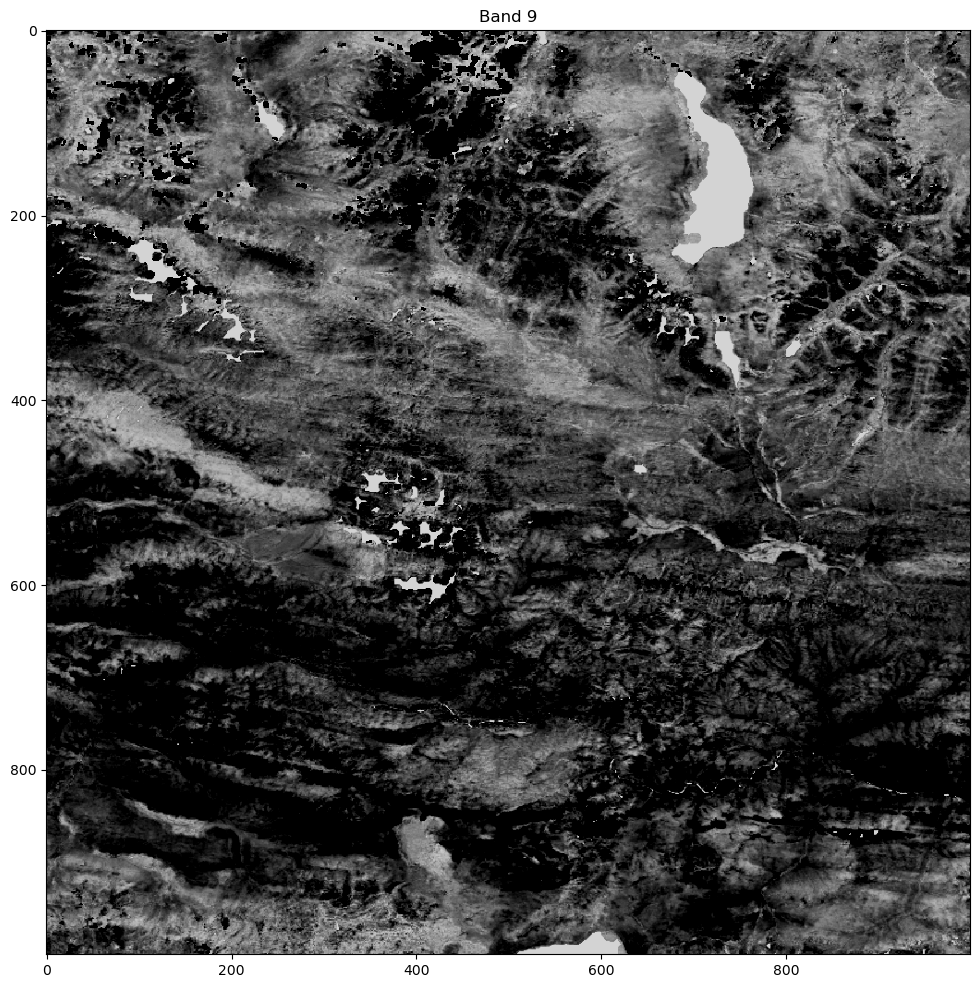

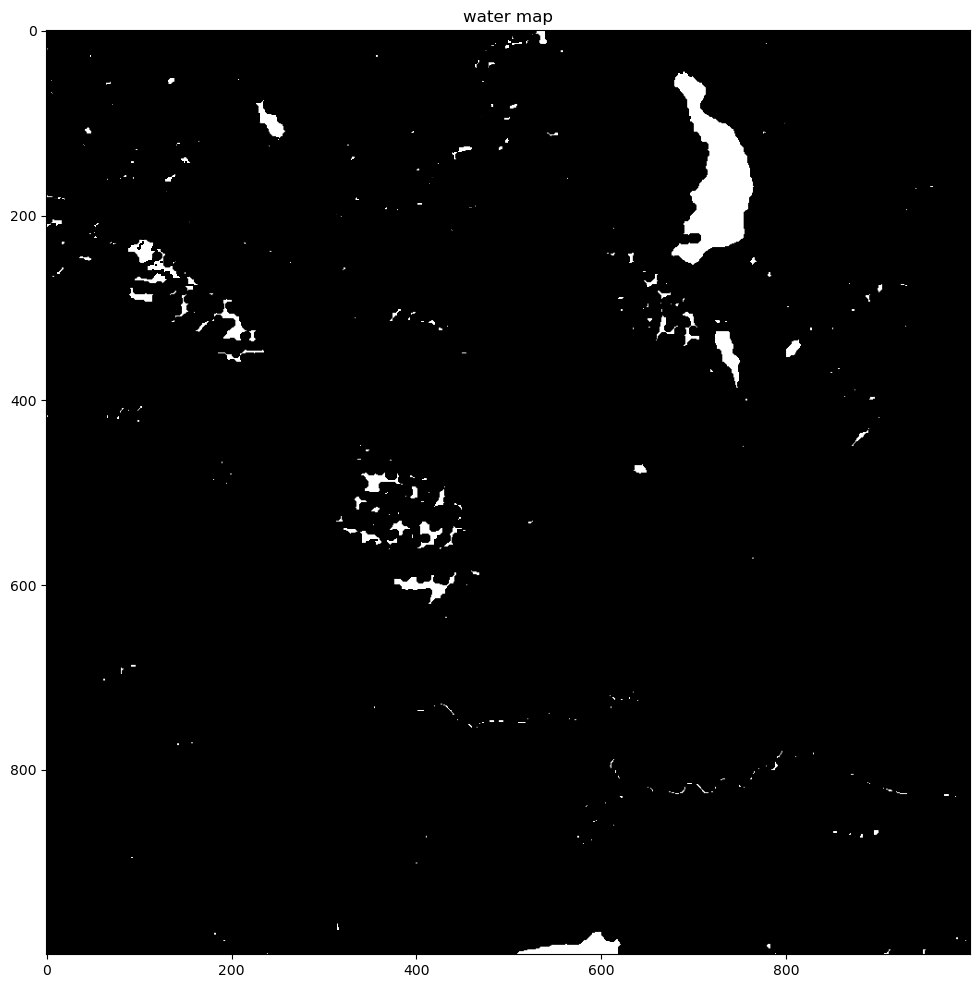

In [2]:
# 2. Check TIR band 9 and Water Map 
import numpy as np
tir_data, water_map = h5_dataDict['tir_mean'], h5_dataDict['ndwi']

print(f'TIR data shape: {tir_data.shape}, max:{np.max(tir_data)}, min:{np.min(tir_data)}, mean:{np.sum(tir_data)/np.count_nonzero(tir_data)}')
print(f'Water Map data shape: {water_map.shape}, max:{np.max(water_map)}, min:{np.min(water_map)}')


from matplotlib import pyplot as plt
def plot_single_band(arr, vmin, vmax, name=''):
    plt.figure(figsize=(12,12))
    plt.imshow(arr, cmap='grey', vmin=vmin, vmax=vmax)
    plt.title(name)
    plt.show()
    plt.close()

plot_single_band(tir_data[0,:,:], vmin=900, vmax=1000, name='Band 9')
plot_single_band(water_map, vmin=0, vmax=1, name='water map')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


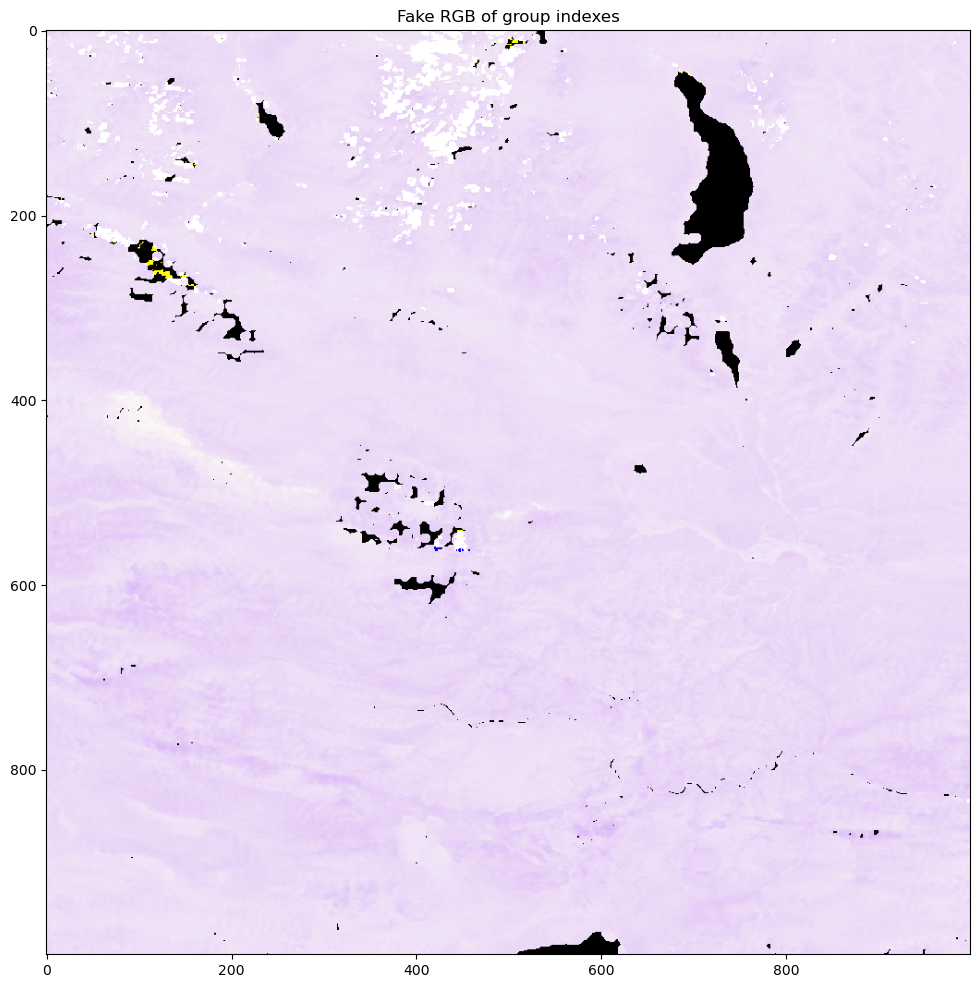

In [3]:
# 3. Check group indexes using map water
import warnings
warnings.filterwarnings('ignore')

non_water_map = np.ones_like(water_map)-water_map
tir_nowater = np.zeros_like(tir_data)
for i in range(tir_data.shape[0]):
    tir_nowater[i,:,:] = tir_data[i]*non_water_map

def calc_index(arr):
    b10 = arr[0].astype(np.float64)
    b11 = arr[1].astype(np.float64)
    b12 = arr[2].astype(np.float64)
    b13 = arr[3].astype(np.float64)
    b14 = arr[4].astype(np.float64)
    nodata_value = -9999
    # nodata_mask = b10[b10==nodata_value]*b11[b11==nodata_value]*b12[b12==nodata_value]*b13[b13==nodata_value]*b14[b14==nodata_value]
    nodata_mask = np.where(b10 == nodata_value, 0, 1) * np.where(b11 == nodata_value, 0, 1) * np.where(
        b12 == nodata_value, 0, 1) * np.where(b13 == nodata_value, 0, 1) * np.where(b14 == nodata_value, 0, 1)

    garnet_index = np.array(((b12 + b14) / b13), dtype=np.float64) * nodata_mask
    # garnet_index[garnet_index==nodata_mask]=nodata_value

    carbonate_index = np.array((b13 / b14), dtype=np.float64) * nodata_mask
    # carbonate_index[carbonate_index==nodata_mask]=nodata_value

    mineral_index = np.array((b12 / b13) * (b14 / b13), dtype=np.float64) * nodata_mask
    # mineral_index[mineral_index==nodata_mask]=nodata_value

    rock_index = np.array((b10 / b12) * (b13 / b12), dtype=np.float64) * nodata_mask
    # rock_index[rock_index==nodata_mask]=nodata_value
    qi = np.array((b11 * b11) / (b10 * b12), dtype=np.float64) * nodata_mask
    # qi[qi==nodata_mask]=nodata_value
    '''
    Garnet index, 
    Mafic mineral index, 
    Quartz mineral rock index, 
    Quartz index, 
    Carbonate index
    '''

    rock_index[np.isnan(rock_index)] = 0
    mineral_index[np.isnan(mineral_index)] = 0
    qi[np.isnan(qi)] = 0
    garnet_index[np.isnan(garnet_index)] = 0
    carbonate_index[np.isnan(carbonate_index)] = 0

    index_result = np.stack(
        [garnet_index * 1000, mineral_index * 1000, rock_index * 1000, qi * 1000, carbonate_index * 1000, ])

    return index_result

index_result = calc_index(tir_nowater)
# print(index_result.shape)

# Normalize to [0,1]
norm_index = np.zeros_like(index_result)
for i in range(index_result.shape[0]):
    norm_index[i] = (index_result[i]-index_result[i].min())/(index_result[i].max()-index_result[i].min())*non_water_map

plt.figure(figsize=(12,12))
plt.imshow(norm_index[[0,1,3]].transpose(1,2,0))
plt.title("Fake RGB of group indexes")
plt.show()
plt.close()

latitude shape: (1000, 1000), longitude shape: (1000, 1000)


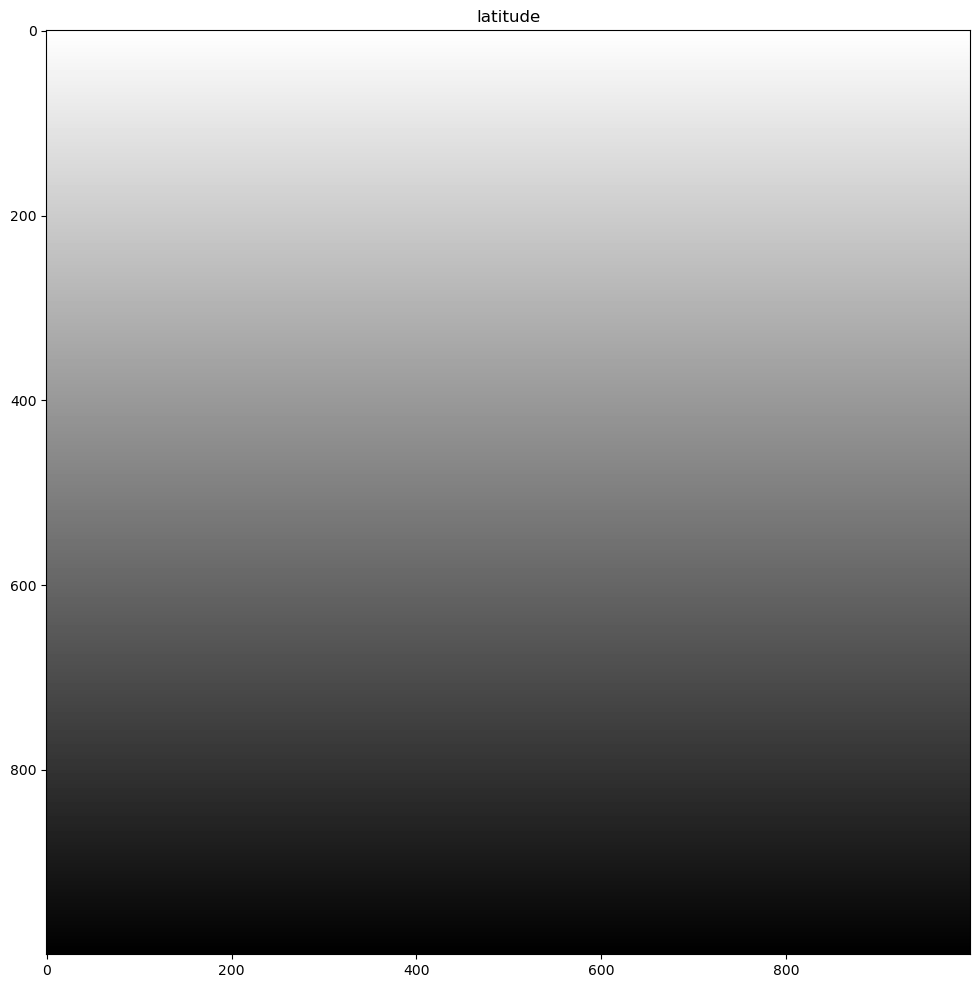

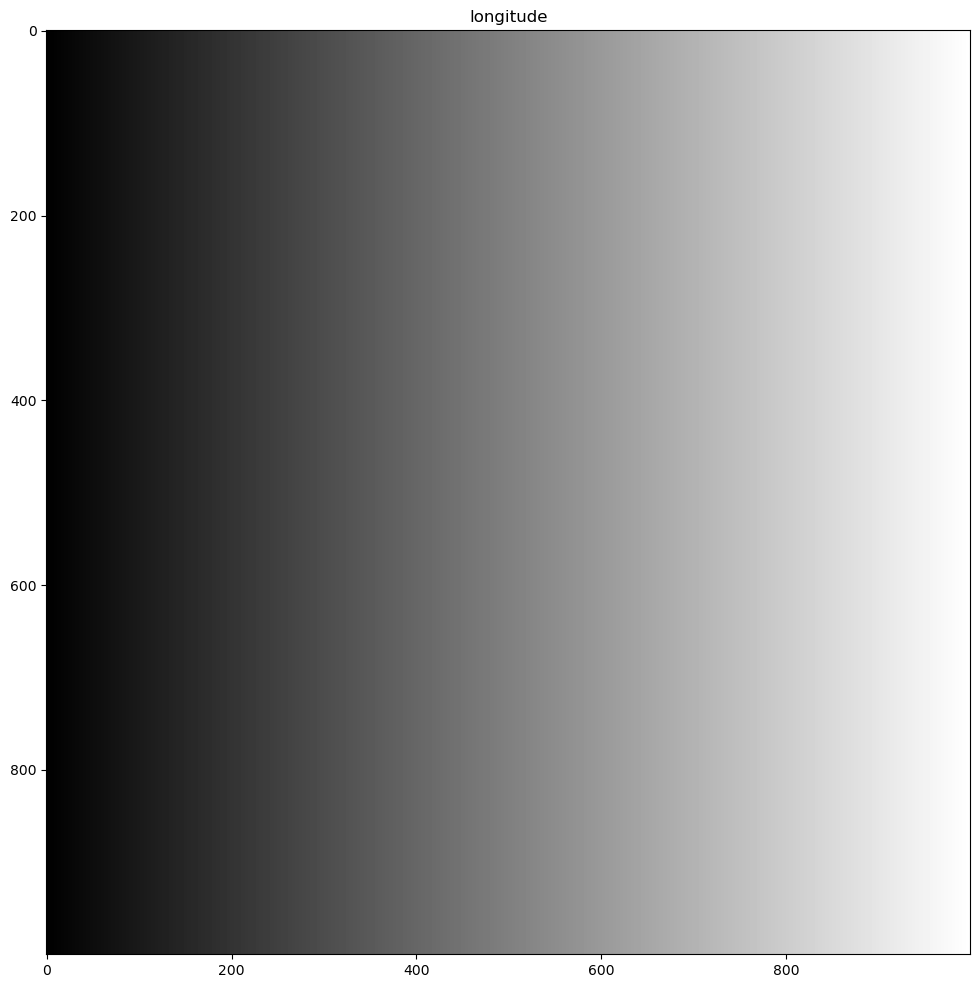

| 0.00, 0.00, 85.00|
| 0.00,-0.00, 30.00|
| 0.00, 0.00, 1.00|


In [4]:
# 4. Check the geolocaltion, generate geoTransform metrix, and reproject the CRS EPSG:4326 to EPSG:3857
latitude, longitude = h5_dataDict['latitude'], h5_dataDict['longitude']
print(f'latitude shape: {latitude.shape}, longitude shape: {longitude.shape}')
plot_single_band(latitude, vmin=29, vmax=30, name='latitude')
plot_single_band(longitude, vmin=85, vmax=86, name='longitude')


def get_rasterio_meta(latitude, longitude):
    h, w = latitude.shape
    pixelHeight = (np.max(latitude) - np.min(latitude)) / (h - 1)
    pixelWidth = (np.max(longitude) - np.min(longitude)) / (w - 1)
    originX = longitude[0, 0]
    originY = latitude[0, 0]
    rotationX = 0
    rotationY = 0
    affine = Affine(pixelWidth, rotationX, originX, rotationY, -pixelHeight, originY)
    return affine


import rasterio
from rasterio.transform import Affine
affine = get_rasterio_meta(latitude, longitude)
print(affine)

In [5]:
# 5. Save the tiff files
from pyproj import CRS

def writeindex2GeoTiff(output_file, data, affine, crs=CRS.from_epsg(4326), dtype=rasterio.int16,
                       reproject2epsg3857=True):
    descriptions = [
        "Garnet Index: (b12 + b14) / b13) *1000 -> Int16",
        "Mafic Mineral Index: (b12 / b13) * (b14 / b13) *1000 ->Int16",
        "Quartz Bearing Rock Index: (b10 / b12) * (b13 / b12) *1000 ->Int16",
        "Quartz Index: (b11 * b11) / (b10 * b12) *1000 ->Int16",
        "Carbonate Index: ((b12 + b14) / b13) *1000 ->Int16",

    ]
    out_meta = {
        "driver": "GTiff",
        "height": data.shape[1],
        "width": data.shape[2],
        "transform": affine,
        "dtype": dtype,
        "crs": crs,
        "count": data.shape[0]
    }

    # Save as EPSG:4326 file
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(data)

    # reproject to EPSG:3857 if needed
    if reproject2epsg3857:
        dst_crs = CRS.from_epsg(3857)
        temp_file = output_file[:-3] + '_3857.tif'
        # reopen EPSG:4326 file and reproject to 3857
        with rasterio.open(output_file) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)

            out_meta.update({
                "crs": dst_crs,
                "transform": transform,
                "width": width,
                "height": height
            })

            # overwrite
            with rasterio.open(temp_file, "w", **out_meta) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )
                for i in range(1, data.shape[0] + 1):
                    dst.update_tags(i, DESCRIPTION=descriptions[i - 1])
        # Delete the 4326 file
        os.remove(output_file)
        os.rename(temp_file, output_file)


def writearray2GeoTiff(output_file, data, affine, crs=CRS.from_epsg(4326), dtype=rasterio.int16,
                       reproject2epsg3857=True):
    out_meta = {
        "driver": "GTiff",
        "height": data.shape[1],
        "width": data.shape[2],
        "transform": affine,
        "dtype": dtype,
        "crs": crs,
        "count": data.shape[0]
    }
    descriptions = [
        "TIR Band 10 [Aster GEDv3] -> Int16",
        "TIR Band 11 [Aster GEDv3] -> Int16",
        "TIR Band 12 [Aster GEDv3] -> Int16",
        "TIR Band 13 [Aster GEDv3] -> Int16",
        "TIR Band 14 [Aster GEDv3] -> Int16",
    ]

    # Save as EPSG:4326 file
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(data)

    # reproject to EPSG:3857 if needed
    if reproject2epsg3857:
        dst_crs = CRS.from_epsg(3857)
        temp_file = output_file[:-3] + '_3857.tif'
        # reopen EPSG:4326 file and reproject to 3857
        with rasterio.open(output_file) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)

            out_meta.update({
                "crs": dst_crs,
                "transform": transform,
                "width": width,
                "height": height
            })

            # overwrite
            with rasterio.open(temp_file, "w", **out_meta) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )
                for i in range(1, data.shape[0] + 1):
                    dst.update_tags(i, DESCRIPTION=descriptions[i - 1])

        # Delete the 4326 file
        os.remove(output_file)
        os.rename(temp_file, output_file)


def writeobs2GeoTiff(output_file, data, affine, crs=CRS.from_epsg(4326), dtype=rasterio.int16,
                     reproject2epsg3857=True):
    out_meta = {
        "driver": "GTiff",
        "height": data.shape[1],
        "width": data.shape[2],
        "transform": affine,
        "dtype": dtype,
        "crs": crs,
        "count": 1
    }
    descriptions = [
        "TIR Observations [Aster GEDv3] -> Int16",
    ]

    # Save as EPSG:4326 file
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(data)

    # reproject to EPSG:3857 if needed
    if reproject2epsg3857:
        dst_crs = CRS.from_epsg(3857)
        temp_file = output_file[:-3] + '_3857.tif'
        # reopen EPSG:4326 file and reproject to 3857
        with rasterio.open(output_file) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)

            out_meta.update({
                "crs": dst_crs,
                "transform": transform,
                "width": width,
                "height": height
            })

            # overwrite
            with rasterio.open(temp_file, "w", **out_meta) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )
                for i in range(1, data.shape[0] + 1):
                    dst.update_tags(i, DESCRIPTION=descriptions[i - 1])

        # Delete the 4326 file
        os.remove(output_file)
        os.rename(temp_file, output_file)


def writestd2GeoTiff(output_file, data, affine, crs=CRS.from_epsg(4326), dtype=rasterio.int16,
                     reproject2epsg3857=True):
    out_meta = {
        "driver": "GTiff",
        "height": data.shape[1],
        "width": data.shape[2],
        "transform": affine,
        "dtype": dtype,
        "crs": crs,
        "count": data.shape[0]
    }
    descriptions = [
        "TIR std Band 10 [Aster GEDv3] -> Float32",
        "TIR std Band 11 [Aster GEDv3] -> Float32",
        "TIR std Band 12 [Aster GEDv3] -> Float32",
        "TIR std Band 13 [Aster GEDv3] -> Float32",
        "TIR std Band 14 [Aster GEDv3] -> Float32",

    ]

    # Save as EPSG:4326 file
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(data)

    # reproject to EPSG:3857 if needed
    if reproject2epsg3857:
        dst_crs = CRS.from_epsg(3857)
        temp_file = output_file[:-3] + '_3857.tif'
        # reopen EPSG:4326 file and reproject to 3857
        with rasterio.open(output_file) as src:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds)

            out_meta.update({
                "crs": dst_crs,
                "transform": transform,
                "width": width,
                "height": height
            })

            # overwrite
            with rasterio.open(temp_file, "w", **out_meta) as dst:
                for i in range(1, src.count + 1):
                    reproject(
                        source=rasterio.band(src, i),
                        destination=rasterio.band(dst, i),
                        src_transform=src.transform,
                        src_crs=src.crs,
                        dst_transform=transform,
                        dst_crs=dst_crs,
                        resampling=Resampling.nearest
                    )
                for i in range(1, data.shape[0] + 1):
                    dst.update_tags(i, DESCRIPTION=descriptions[i - 1])
        # Delete the 4326 file
        os.remove(output_file)
        os.rename(temp_file, output_file)


tmp_index = f"{filename.split('.')[0]}_groupIndexes.tiff"
tmp_tif = f"{filename.split('.')[0]}_emisMean.tiff"
tmp_std = f"{filename.split('.')[0]}_emisSDev.tiff"
tmp_obs = f"{filename.split('.')[0]}_observations.tiff"

writeindex2GeoTiff(tmp_index, index_result, affine, crs=CRS.from_epsg(4326), dtype=rasterio.int16, reproject2epsg3857=False)
writearray2GeoTiff(tmp_tif, h5_dataDict["tir_mean"], affine, crs=CRS.from_epsg(4326), dtype=rasterio.int16, reproject2epsg3857=False)
writestd2GeoTiff(tmp_std, h5_dataDict["tir_std"], affine, crs=CRS.from_epsg(4326), dtype=rasterio.float32, reproject2epsg3857=False)
writeobs2GeoTiff(tmp_obs, np.expand_dims(h5_dataDict["observations"], axis=0), affine, crs=CRS.from_epsg(4326), dtype=rasterio.int16, reproject2epsg3857=False)